## Tarea 3 - Aprendizaje Automático
Vicente Mieres

In [3]:
# imports
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import numpy as np

Parte 1 - Carga y procesamiento de datos

In [4]:
def load_images_and_labels(file_path):

    # Ruta al archivo de texto que contiene las imágenes y las etiquetas
    list_of_images_path = os.path.join(file_path, 'list_of_images.txt')

    # Lista para almacenar las imágenes y sus etiquetas
    images = []
    labels = []

    # Leer el archivo list_of_images
    with open(list_of_images_path, 'r') as file:
        for line in file.readlines():
            img_name, label = line.strip().split()  # Separar el nombre de la imagen y la etiqueta
            img_path = os.path.join(file_path, 'images', img_name)  # Ruta completa de la imagen
            
            # Cargar la imagen
            image = Image.open(img_path).convert('RGB')  # Convertir la imagen a RGB
            image = image.resize((224, 224))  # Redimensionar a 224x224 (tamaño estándar)
            image_array = np.array(image) / 255.0  # Normalizar la imagen entre 0 y 1
            
            # Añadir la imagen y su etiqueta a las listas
            images.append(image_array)
            labels.append(label)

    # Convertir las listas a arrays de numpy
    images = np.array(images)
    labels = np.array(labels)

    return images, labels


In [5]:
voc_path = 'C:/Users/vicen/proyects/AprendizajeAutomatico/Tarea 3/VOC_val/'
images_voc, labels_voc  = load_images_and_labels(voc_path)

In [9]:
paris_path = 'C:/Users/vicen/proyects/AprendizajeAutomatico/Tarea 3/Paris_val/'
images_paris, labels_paris  = load_images_and_labels(paris_path)    

In [6]:
simple_path = 'C:/Users/vicen/proyects/AprendizajeAutomatico/Tarea 3/simple1K/'
images_simple, labels_simple  = load_images_and_labels(simple_path)

Parte 2 - Extracción de características

In [11]:
# Preprocesamiento para resnet

from torchvision import transforms

# Transformaciones para ResNet18
transform_resnet = transforms.Compose([
    transforms.ToTensor(),  # Convertir imagen a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización según ImageNet
])

# Aplicar la transformación a todas las imágenes
img_resnet_voc = [transform_resnet(Image.fromarray((img * 255).astype(np.uint8))) for img in images_voc]
img_resnet_paris = [transform_resnet(Image.fromarray((img * 255).astype(np.uint8))) for img in images_paris]
img_resnet_simple = [transform_resnet(Image.fromarray((img * 255).astype(np.uint8))) for img in images_simple]


In [23]:
import torch
from torchvision import models

# Cargar ResNet18 preentrenado
resnet18 = models.resnet18(pretrained=True)
resnet18.eval()  # Modo de evaluación

# Función para obtener las características
def get_resnet18_features(image_tensor):
    with torch.no_grad():
        features = resnet18(image_tensor.unsqueeze(0))  # Añadir batch dimension
    return features

# Extracción de características
res_ft_voc = [get_resnet18_features(img) for img in img_resnet_voc]
resnet_features_voc = torch.cat(res_ft_voc)  

res_ft_paris = [get_resnet18_features(img) for img in img_resnet_paris]
resnet_features_paris = torch.cat(res_ft_paris)  

res_ft_simple = [get_resnet18_features(img) for img in img_resnet_simple]
resnet_features_simple = torch.cat(res_ft_simple)  

c:\Users\vicen\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\vicen\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
# Preprocesamiento para CLIP

from transformers import CLIPProcessor

# Cargar el procesador CLIP
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Preprocesar las imágenes para CLIP
img_clip_voc = [clip_processor(images=Image.fromarray((img * 255).astype(np.uint8)), return_tensors="pt") for img in images_voc]
img_clip_paris = [clip_processor(images=Image.fromarray((img * 255).astype(np.uint8)), return_tensors="pt") for img in images_paris]
img_clip_simple = [clip_processor(images=Image.fromarray((img * 255).astype(np.uint8)), return_tensors="pt") for img in images_simple]


c:\Users\vicen\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [21]:
from transformers import CLIPModel

# Cargar el modelo CLIP
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

# Extracción de características
with torch.no_grad():
    clip_features_voc = [clip_model.get_image_features(**input_clip) for input_clip in img_clip_voc]
clip_features_voc = torch.cat(clip_features_voc) 

with torch.no_grad():
    clip_features_paris = [clip_model.get_image_features(**input_clip) for input_clip in img_clip_paris]
clip_features_paris = torch.cat(clip_features_paris) 

with torch.no_grad():
    clip_features_simple = [clip_model.get_image_features(**input_clip) for input_clip in img_clip_simple]
clip_features_simple = torch.cat(clip_features_simple) 


Parte 3 - similitud coseno

In [61]:
from sklearn.metrics.pairwise import cosine_similarity


# Ejemplo: Comparar la imagen de consulta (index 0) con todas las demás usando ResNet18
query_resnet_voc = resnet_features_voc[0].unsqueeze(0)  # Características de la imagen de consulta
similarity_resnet_voc = cosine_similarity(query_resnet_voc, resnet_features_voc)

query_resnet_paris = resnet_features_paris[0].unsqueeze(0)  # Características de la imagen de consulta
similarity_resnet_paris = cosine_similarity(query_resnet_paris, resnet_features_paris)

query_resnet_simple = resnet_features_simple[0].unsqueeze(0)  # Características de la imagen de consulta
similarity_resnet_simple = cosine_similarity(query_resnet_simple, resnet_features_simple)

# CLIP
query_clip_voc = clip_features_voc[0].unsqueeze(0)
similarity_clip_voc = cosine_similarity(query_clip_voc, clip_features_voc)

query_clip_paris = clip_features_paris[0].unsqueeze(0)
similarity_clip_paris = cosine_similarity(query_clip_paris, clip_features_paris)

query_clip_simple = clip_features_simple[0].unsqueeze(0)
similarity_clip_simple = cosine_similarity(query_clip_simple, clip_features_simple)


Parte 4 - Metricas

In [ ]:
from sklearn.metrics import average_precision_score

# Calcular mAP para ResNet
true_labels_voc = np.array([labels == labels[0] for labels in labels_voc]) 
true_labels_paris = np.array([labels == labels[0] for labels in labels_paris]) 
true_labels_simple = np.array([labels == labels[0] for labels in labels_simple]) 

# RESNET
map_resnet_voc = average_precision_score(true_labels_voc, similarity_resnet_voc.flatten())
map_resnet_paris = average_precision_score(true_labels_paris, similarity_resnet_paris.flatten())
map_resnet_simple = average_precision_score(true_labels_simple, similarity_resnet_simple.flatten())

# Lo mismo para CLIP y DINOv2
map_clip_voc = average_precision_score(true_labels_voc, similarity_clip_voc.flatten())
map_clip_paris = average_precision_score(true_labels_paris, similarity_clip_paris.flatten())
map_clip_simple = average_precision_score(true_labels_simple, similarity_clip_simple.flatten())


c:\Users\vicen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\vicen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\vicen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\vicen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\vicen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:1033: UserWarning: No positive class found in y

In [ ]:
map_resnet_voc

0.0

In [78]:
map_resnet_simple

0.0

In [79]:
map_resnet_paris

0.0

In [80]:
map_clip_voc

0.0

In [81]:
map_clip_simple

0.0

In [82]:
map_clip_paris

0.0

Recall

c:\Users\vicen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


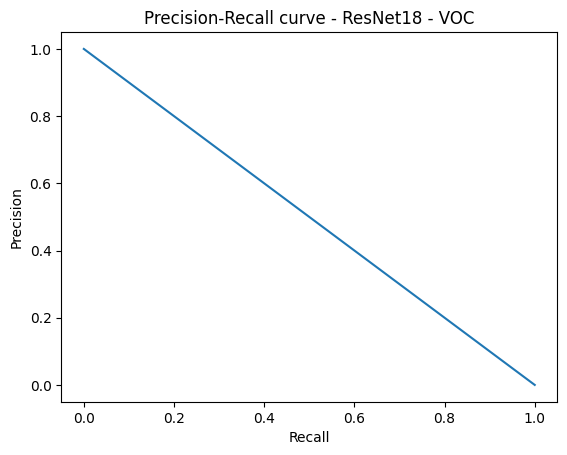

c:\Users\vicen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


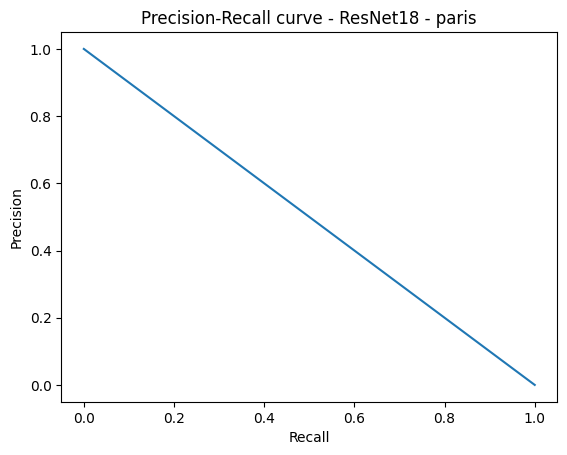

c:\Users\vicen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


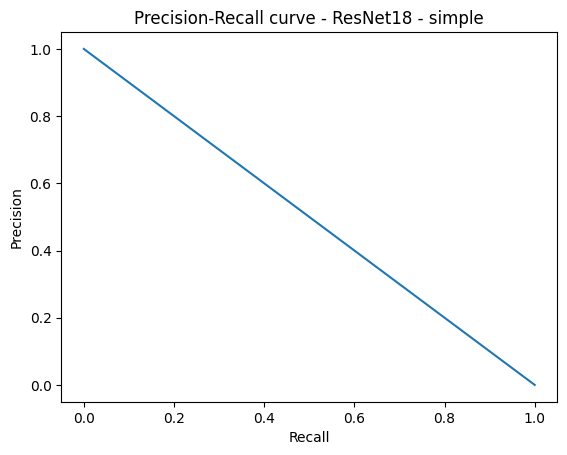

In [66]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Graficar Precision-Recall para ResNet
precision_resnet, recall_resnet, _ = precision_recall_curve(true_labels_voc.flatten(), similarity_resnet_voc.flatten())
plt.plot(recall_resnet, precision_resnet)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve - ResNet18 - VOC')
plt.show()

precision_resnet, recall_resnet, _ = precision_recall_curve(true_labels_paris.flatten(), similarity_resnet_paris.flatten())
plt.plot(recall_resnet, precision_resnet)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve - ResNet18 - paris')
plt.show()


precision_resnet, recall_resnet, _ = precision_recall_curve(true_labels_simple.flatten(), similarity_resnet_simple.flatten())
plt.plot(recall_resnet, precision_resnet)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve - ResNet18 - simple')
plt.show()

c:\Users\vicen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


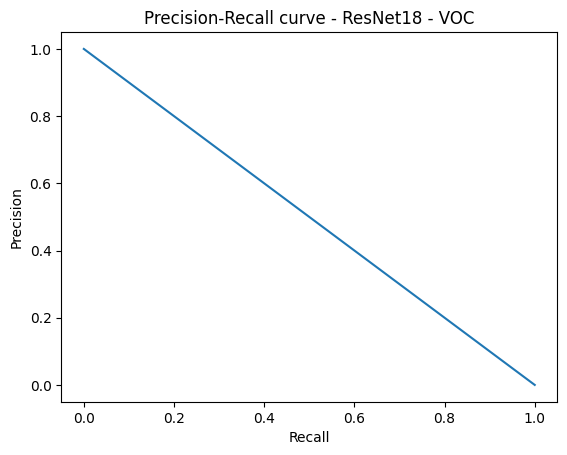

c:\Users\vicen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


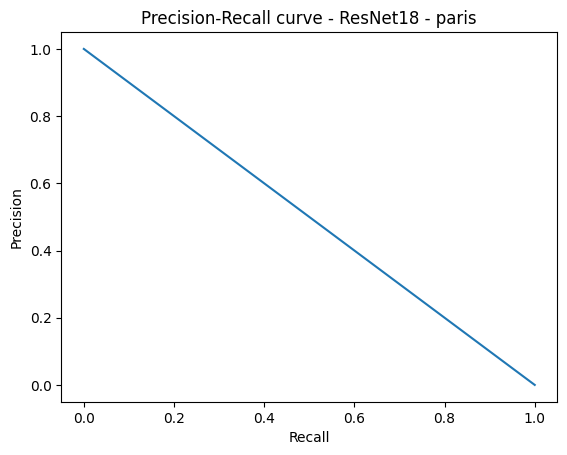

c:\Users\vicen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


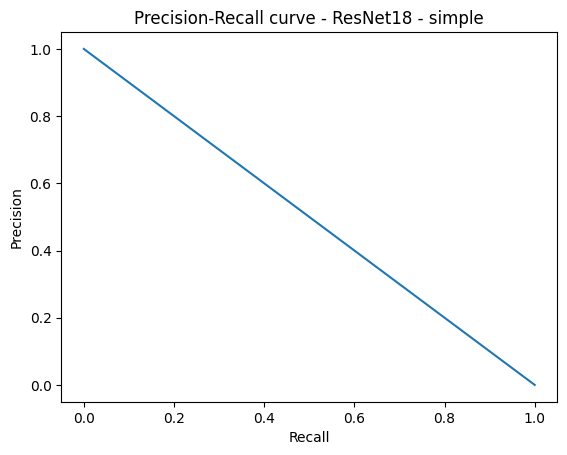

In [67]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Graficar Precision-Recall para ResNet
precision_resnet, recall_resnet, _ = precision_recall_curve(true_labels_voc.flatten(), similarity_clip_voc.flatten())
plt.plot(recall_resnet, precision_resnet)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve - ResNet18 - VOC')
plt.show()

precision_resnet, recall_resnet, _ = precision_recall_curve(true_labels_paris.flatten(), similarity_clip_paris.flatten())
plt.plot(recall_resnet, precision_resnet)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve - ResNet18 - paris')
plt.show()


precision_resnet, recall_resnet, _ = precision_recall_curve(true_labels_simple.flatten(), similarity_clip_simple.flatten())
plt.plot(recall_resnet, precision_resnet)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve - ResNet18 - simple')
plt.show()

Parte 5 - Mejores resultados

In [76]:
import numpy as np

# Función para obtener los mejores y peores ejemplos
def get_best_worst_examples(similarity_scores, true_labels, n=5):
    sorted_indices = np.argsort(similarity_scores, axis=1)
    best_examples = sorted_indices[:, :n]
    worst_examples = sorted_indices[:, -n:]
    return best_examples, worst_examples

# Obtener los mejores y peores ejemplos para ResNet
best_resnet_1, worst_resnet_1 = get_best_worst_examples(similarity_resnet_voc, true_labels_voc)
best_resnet_2, worst_resnet_2 = get_best_worst_examples(similarity_resnet_paris, true_labels_paris)
best_resnet_3, worst_resnet_3 = get_best_worst_examples(similarity_resnet_simple, true_labels_simple)

# También para CLIP y DINOv2
best_clip, worst_clip = get_best_worst_examples(similarity_clip_voc, true_labels_voc)
best_clip_2, worst_clip_2 = get_best_worst_examples(similarity_clip_paris, true_labels_paris)
best_clip_3, worst_clip_3 = get_best_worst_examples(similarity_clip_simple, true_labels_simple)


In [93]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def mostrar_imagenes_en_filas(indices_1, indices_2, listado_imagenes):
    """
    Muestra dos filas de imágenes.
    
    :param indices_1: Arreglo con los índices de las imágenes para la primera fila.
    :param indices_2: Arreglo con los índices de las imágenes para la segunda fila.
    :param listado_imagenes: Lista con las imágenes a mostrar.
    :param tamanio_imagen: El tamaño al que se redimensionarán las imágenes (default 224x224).
    """
    # Crear una figura con 2 filas y tantas columnas como imágenes
    fig, axes = plt.subplots(2, len(indices_1), figsize=(12, 6))
    
    # Primera fila: Mostrar imágenes de indices_1
    for i, idx in enumerate(indices_1):
        ax = axes[0, i]
        ax.imshow(listado_imagenes[idx])  # Redimensionar la imagen
        ax.axis('off')  # Desactivar los ejes
        ax.set_title(f"Imagen {idx + 1}")  # Título opcional

    # Segunda fila: Mostrar imágenes de indices_2
    for i, idx in enumerate(indices_2):
        ax = axes[1, i]
        ax.imshow(listado_imagenes[idx])  # Redimensionar la imagen
        ax.axis('off')  # Desactivar los ejes
        ax.set_title(f"Imagen {idx + 1}")  # Título opcional
    
    plt.tight_layout()
    plt.show()


In [95]:
best_resnet_1, worst_resnet_1

(array([[1586, 2560, 2433, 1283,  223]]),
 array([[2585, 3027, 3045, 4502,    0]]))

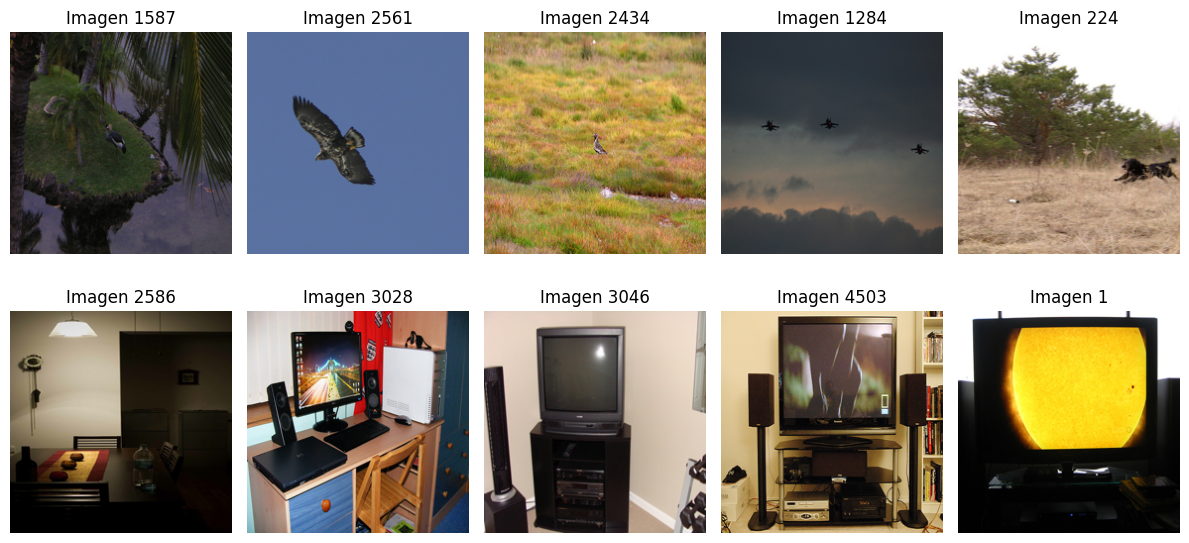

In [94]:
lst = [1586, 2560, 2433, 1283,  223]
lst2 = [2585, 3027, 3045, 4502, 0]

mostrar_imagenes_en_filas(lst, lst2, images_voc)

In [84]:
best_resnet_2, worst_resnet_2 

(array([[835, 860, 729, 148, 599]]), array([[ 9, 55,  1,  0,  2]]))

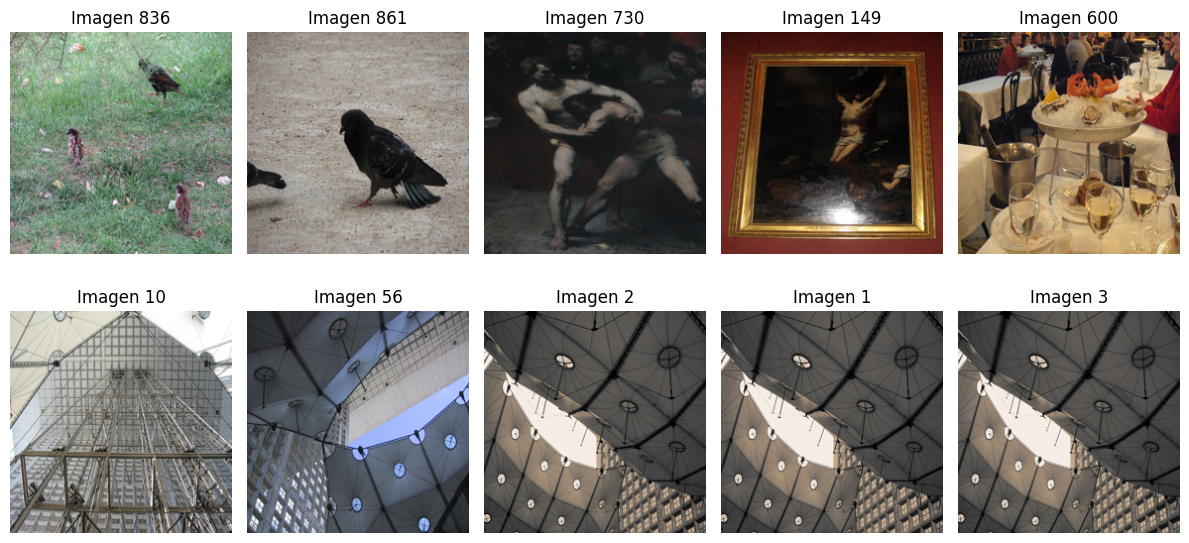

In [ ]:
lst = [835, 860, 729, 148, 599]
lst2 = [ 9, 55,  1,  0,  2]

mostrar_imagenes_en_filas(lst, lst2, images_paris)

In [85]:
best_resnet_3, worst_resnet_3 

(array([[ 795,   35, 1319, 1041,  409]]), array([[30,  2, 28, 19,  0]]))

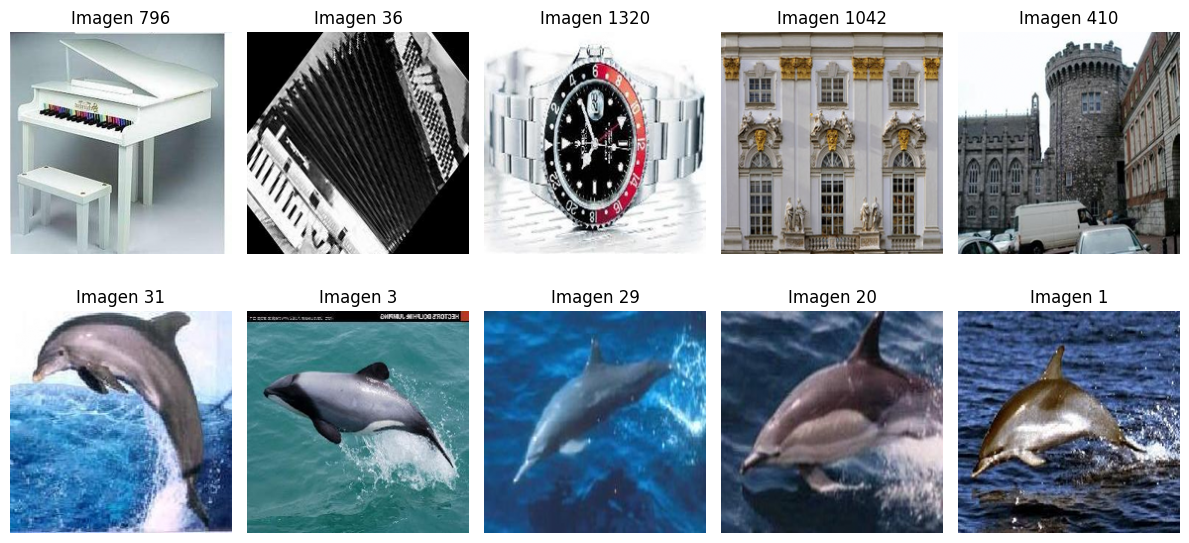

In [98]:
lst = [ 795,   35, 1319, 1041,  409]
lst2 = [30,  2, 28, 19,  0]

mostrar_imagenes_en_filas(lst, lst2, images_simple)

In [86]:
best_clip, worst_clip

(array([[1589, 4586, 3703,  191, 4261]]),
 array([[1395,  734, 4610, 1536,    0]]))

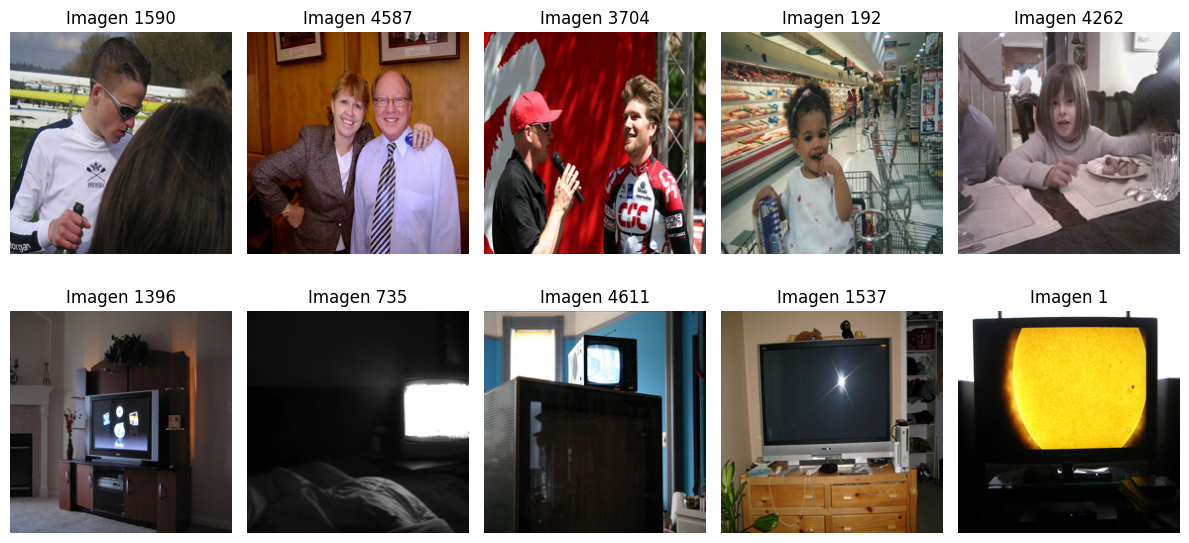

In [102]:
lst = [1589, 4586, 3703,  191, 4261]
lst2 = [1395,  734, 4610, 1536, 0]

mostrar_imagenes_en_filas(lst, lst2, images_voc)

In [87]:
best_clip_2, worst_clip_2

(array([[970, 929, 644, 246, 118]]), array([[55, 74,  0,  1,  2]]))

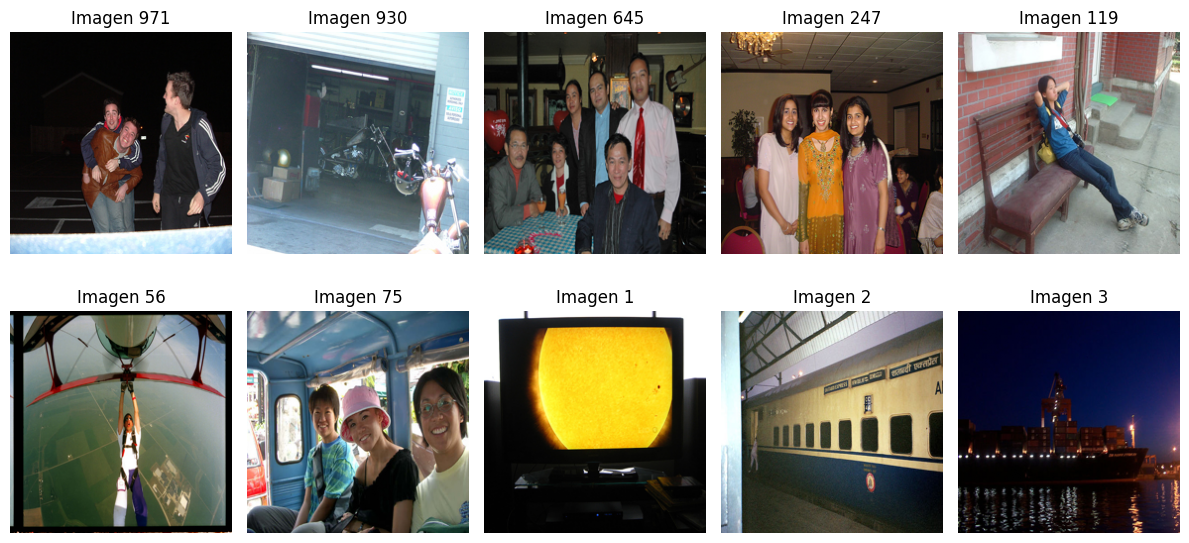

In [103]:
lst = [970, 929, 644, 246, 118]
lst2 = [55, 74,  0,  1,  2]

mostrar_imagenes_en_filas(lst, lst2, images_voc)

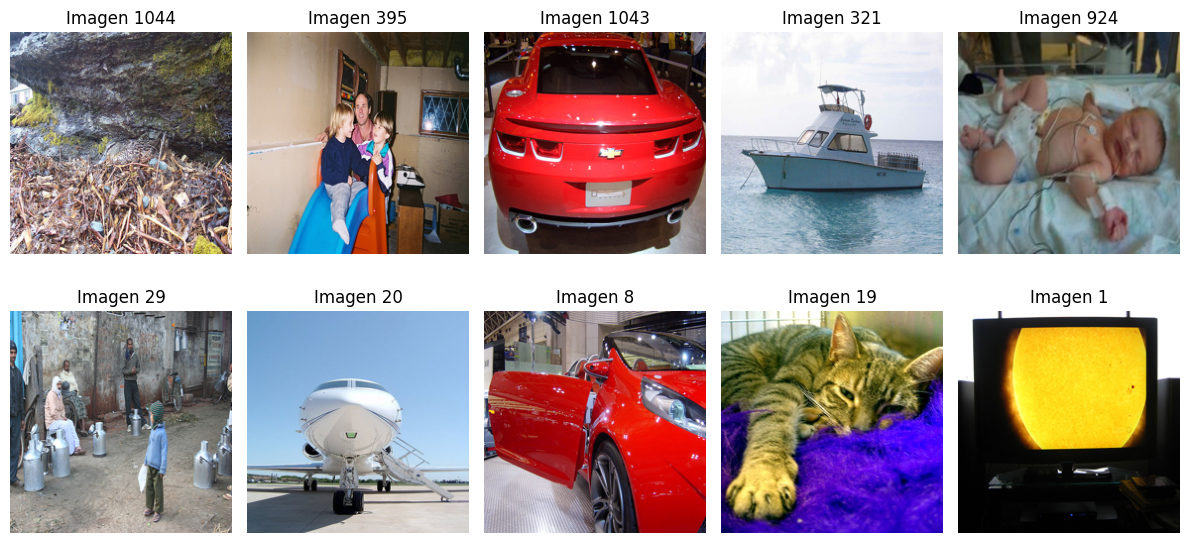

In [104]:
lst = [1043,  394, 1042,  320,  923]
lst2 = [28, 19,  7, 18,  0]

mostrar_imagenes_en_filas(lst, lst2, images_voc)